In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------
# 데이터 로드 & 컬럼 정리
# -----------------------------
vip_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\vip_final.csv")
vip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16596 entries, 0 to 16595
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   기준년월            16596 non-null  int64  
 1   세그먼트ID          16596 non-null  object 
 2   요구불예금잔액         16596 non-null  float64
 3   거치식예금잔액         16596 non-null  float64
 4   적립식예금잔액         16596 non-null  float64
 5   수익증권잔액          16596 non-null  float64
 6   신탁잔액            16596 non-null  float64
 7   퇴직연금잔액          16596 non-null  float64
 8   여신한도금액          16596 non-null  float64
 9   여신_운전자금대출잔액     16596 non-null  float64
 10  여신_시설자금대출잔액     16596 non-null  float64
 11  외환_수출실적금액       16596 non-null  float64
 12  외환_수입실적금액       16596 non-null  float64
 13  신용카드사용금액        16596 non-null  float64
 14  체크카드사용금액        16596 non-null  float64
 15  창구거래금액          16596 non-null  float64
 16  인터넷뱅킹거래금액       16596 non-null  float64
 17  스마트뱅킹거래금액       16596 non-null 

In [2]:
# 핵심 피처 리스트
base_features = [
    '총거래금액', 
    '총거래건수', 
    '총예금잔액', 
    '총여신잔액', 
    '대출비중', 
    '상품다양성지수', 
    '총카드사용액', 
    '외환_수출실적금액', 
    '외환_수입실적금액',
    '외부_여신시설자금', 
    '외부_여신운전자금'
]

# 고정값 피처 (lag 불필요)
static_features = ['법인_고객등급', '전담고객여부']

In [3]:
def create_time_series_features(df, group_col, time_col, feature_cols, 
                                lag_list=[1], rolling_windows=[3]):
    """
    시계열 피처(lag, diff, rolling)를 자동으로 생성하는 함수
    ------------------------------------------
    df : pandas.DataFrame
    group_col : 그룹 기준 (세그먼트ID 등)
    time_col : 시간 기준 (기준년월 등)
    feature_cols : 시계열 피처 생성 대상 컬럼 리스트
    lag_list : 생성할 lag 시차 목록
    rolling_windows : 생성할 rolling 기간 목록
    """
    df = df.copy()
    df = df.sort_values([group_col, time_col])
    g = df.groupby(group_col)
    
    for col in feature_cols:
        # Lag features
        for lag in lag_list:
            new_col = f"{col}_lag{lag}"
            df[new_col] = g[col].shift(lag)
        
        # Diff features (현재 - lag1)
        if 1 in lag_list:
            df[f"{col}_diff1"] = df[col] - df[f"{col}_lag1"]
        
        # Rolling features
        for win in rolling_windows:
            new_col = f"{col}_roll{win}"
            df[new_col] = g[col].transform(lambda x: x.rolling(window=win, min_periods=1).mean())

    # NaN 처리 (초기 구간 등)
    df = df.fillna(0)
    return df

In [4]:
# 기준년월을 datetime으로 변환 (혹시 안 되어 있다면)
# 1) 문자열(YYYYMM) → datetime으로 변환
vip_df['기준년월'] = pd.to_datetime(vip_df['기준년월'], format='%Y%m')

# 2) datetime → period(M)으로 변환
vip_df['기준년월'] = vip_df['기준년월'].dt.to_period('M')

vip_df = vip_df.sort_values(['세그먼트ID', '기준년월'])

# 함수 적용
vip_df_ts = create_time_series_features(
    df=vip_df,
    group_col='세그먼트ID',
    time_col='기준년월',
    feature_cols=base_features,
    lag_list=[1],            # 1개월 전 값
    rolling_windows=[3]      # 최근 3개월 평균
)

print(vip_df_ts.shape)
vip_df_ts.head()

(16596, 95)


,기준년월,세그먼트ID,요구불예금잔액,거치식예금잔액,적립식예금잔액,수익증권잔액,신탁잔액,퇴직연금잔액,여신한도금액,여신_운전자금대출잔액,...,외환_수출실적금액_roll3,외환_수입실적금액_lag1,외환_수입실적금액_diff1,외환_수입실적금액_roll3,외부_여신시설자금_lag1,외부_여신시설자금_diff1,외부_여신시설자금_roll3,외부_여신운전자금_lag1,외부_여신운전자금_diff1,외부_여신운전자금_roll3
0,2022-01,건설업_전문직별 공사업_경상북도_경산시,4522.80,2672.0,125.6,0.0,2503.8,1440.8,9480.0,13320.0,...,0.0,0.0,0.00,0.00,0.000000,0.000000,172600.000000,0.0,0.000000,678400.000000
1,2022-02,건설업_전문직별 공사업_경상북도_경산시,3918.84,2673.0,142.6,0.0,2297.8,1454.8,13340.0,14983.0,...,0.0,0.0,0.00,0.00,172600.000000,3966.666667,174583.333333,678400.0,8600.000000,682700.000000
2,2022-03,건설업_전문직별 공사업_경상북도_경산시,2204.27,943.0,155.4,0.0,2319.2,1446.2,8910.0,12717.9,...,0.0,0.0,0.00,0.00,176566.666667,3966.666667,176566.666667,687000.0,8600.000000,687000.000000
3,2022-04,건설업_전문직별 공사업_경상북도_경산시,1537.49,943.0,168.2,0.0,2156.3,1453.3,8810.0,13010.0,...,0.0,0.0,0.00,0.00,180533.333333,3966.666667,180533.333333,695600.0,8600.000000,695600.000000
4,2022-05,건설업_전문직별 공사업_경상북도_경산시,3330.63,943.0,180.8,0.0,1732.5,1499.5,13410.0,15323.0,...,0.0,0.0,0.03,0.01,184500.000000,4766.666667,184766.666667,704200.0,2833.333333,702277.777778


In [5]:
# ✅ Feature 리스트 다시 구성
feature_cols = []
for col in base_features:
    feature_cols += [col, f"{col}_lag1", f"{col}_diff1", f"{col}_roll3"]
feature_cols += static_features

# ✅ Target
target_col = '이탈여부'

# ✅ X, y
X = vip_df_ts[feature_cols]
y = vip_df_ts[target_col]

print("최종 Feature 수:", len(feature_cols))
print("데이터셋 크기:", X.shape)

최종 Feature 수: 46
데이터셋 크기: (16596, 46)


In [6]:
# 시계열 교차검증 (예: 5번 분할)
tscv = TimeSeriesSplit(n_splits=5)

# 분할 예시 확인
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"[Fold {fold+1}] Train: {len(train_idx)}, Test: {len(test_idx)}")

[Fold 1] Train: 2766, Test: 2766
[Fold 2] Train: 5532, Test: 2766
[Fold 3] Train: 8298, Test: 2766
[Fold 4] Train: 11064, Test: 2766
[Fold 5] Train: 13830, Test: 2766


In [7]:
# -------------------------------
# ① 비교할 모델 정의
# -------------------------------
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbose=-1       # ✅ 로그 끄기
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver='lbfgs'
    )
}


In [8]:
# -------------------------------
# ② 모델 성능 저장용 리스트
# -------------------------------
results = []

# -------------------------------
# ③ 교차검증을 통한 모델 성능 비교
# -------------------------------
for name, model in models.items():
    auc_scores = []
    f1_scores = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        auc_scores.append(roc_auc_score(y_test, y_pred_proba))
        f1_scores.append(precision_recall_fscore_support(y_test, y_pred, average='binary')[2])
    
    results.append({
        'Model': name,
        'Mean AUC': np.mean(auc_scores),
        'Mean F1': np.mean(f1_scores)
    })

# -------------------------------
# ④ 결과 정리
# -------------------------------
results_df = pd.DataFrame(results).sort_values(by='Mean AUC', ascending=False)
print("\n=== 모델 성능 비교 결과 ===")
print(results_df)


=== 모델 성능 비교 결과 ===
                Model  Mean AUC   Mean F1
0             XGBoost  0.935834  0.719323
1            LightGBM  0.930181  0.704663
2        RandomForest  0.917706  0.625436
3  LogisticRegression  0.811218  0.345429


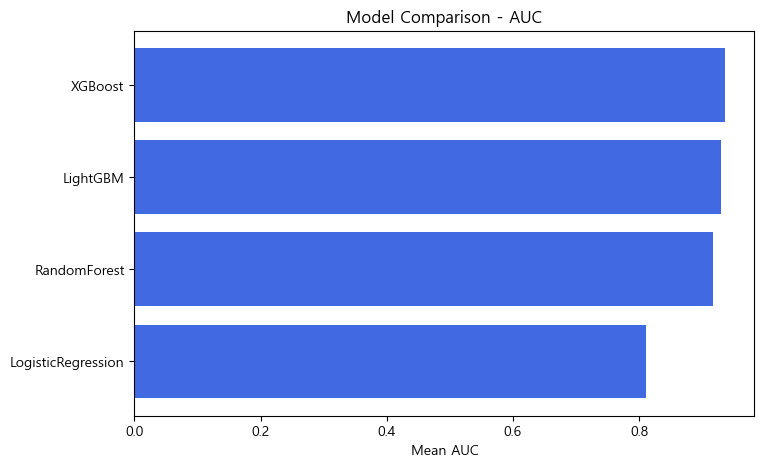

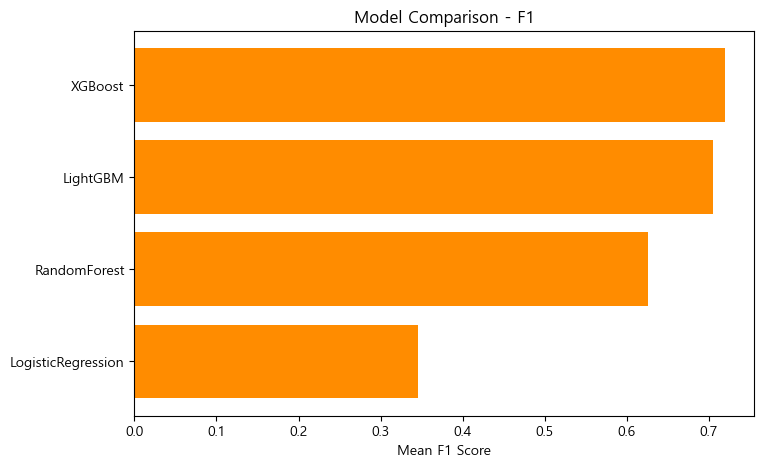

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(results_df['Model'], results_df['Mean AUC'], color='royalblue')
plt.xlabel('Mean AUC')
plt.title('Model Comparison - AUC')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8,5))
plt.barh(results_df['Model'], results_df['Mean F1'], color='darkorange')
plt.xlabel('Mean F1 Score')
plt.title('Model Comparison - F1')
plt.gca().invert_yaxis()
plt.show()